In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import sys
import copy
import matplotlib
%matplotlib inline
sys.path.append("..")
from demo_2_awac import och_2_awac
import adept_envs
import gym
env = gym.make("franka_cabinet_slider_knob_switch_toaster_resetfree-v1")

all_paths = ['/usr/local/google/home/abhishekunique/sim_franka/simplified_awac/recordings/recording_0.pkl',
            '/usr/local/google/home/abhishekunique/sim_franka/simplified_awac/recordings/recording_1.pkl',
            '/usr/local/google/home/abhishekunique/sim_franka/simplified_awac/recordings/recording_2.pkl',
            '/usr/local/google/home/abhishekunique/sim_franka/simplified_awac/recordings/recording_3.pkl',
            '/usr/local/google/home/abhishekunique/sim_franka/simplified_awac/recordings/recording_4.pkl',
             '/usr/local/google/home/abhishekunique/sim_franka/simplified_awac/recordings/recording_5.pkl',
             '/usr/local/google/home/abhishekunique/sim_franka/simplified_awac/recordings/recording_6.pkl',
             '/usr/local/google/home/abhishekunique/sim_franka/simplified_awac/recordings/recording_7.pkl',
            '/usr/local/google/home/abhishekunique/sim_franka/simplified_awac/recordings/recording_8.pkl',]
             
dat = []

for p in all_paths:
    dat_curr = pickle.load(open(p, 'rb'))
    dat += dat_curr
print(len(dat))


[1.]
982


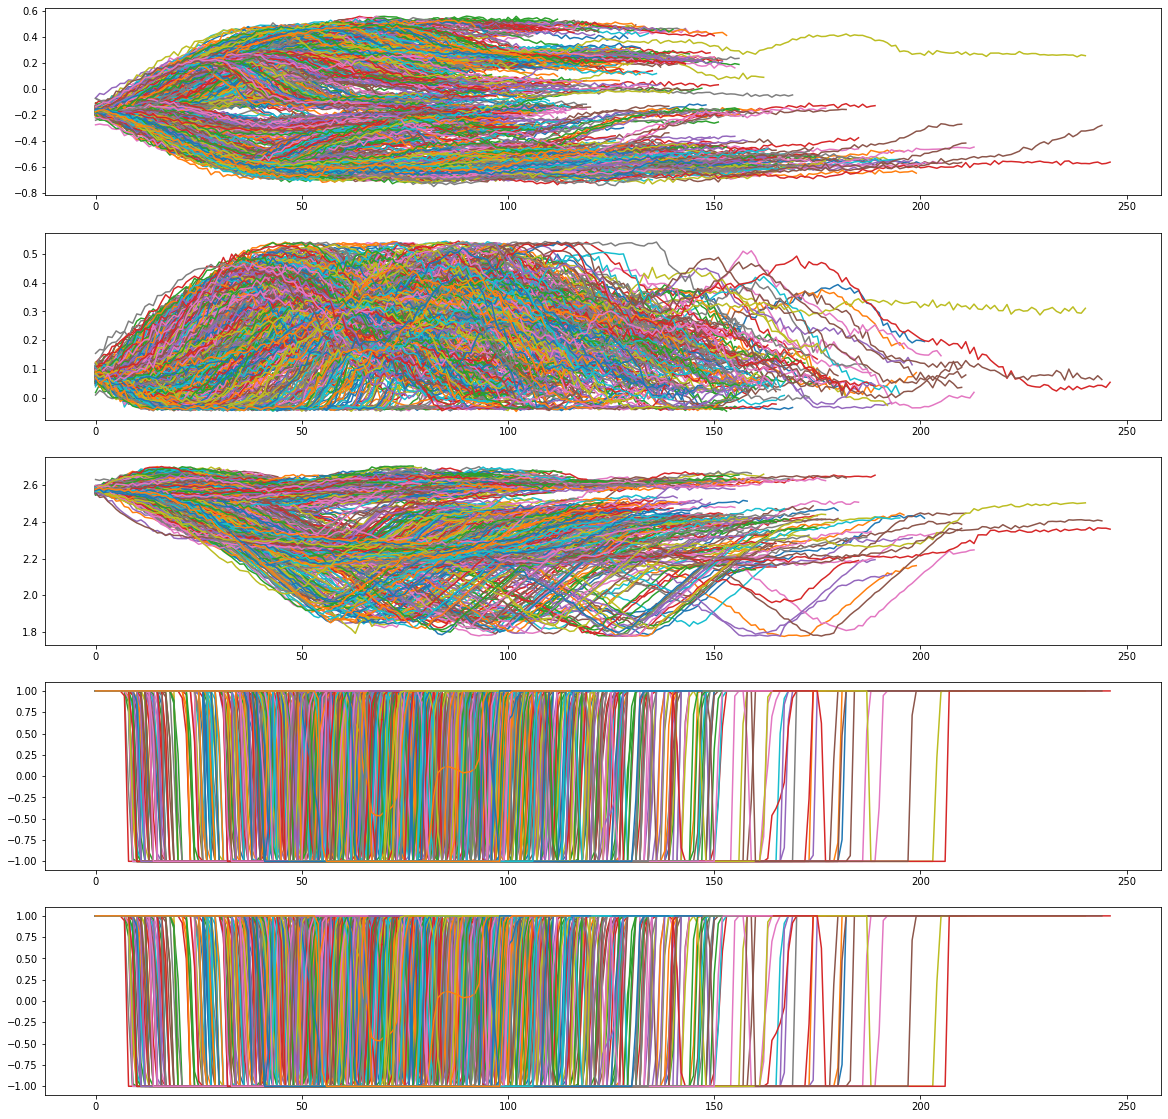

In [2]:
list_awac = och_2_awac(dat)
for path in list_awac:
    mocap_poss = []
    for i in range(path['observations'].shape[0]):
        nmp = path['observations'][i, 8:11] + path['actions'][i, :3]*env.env.range
        #nmp = np.clip(nmp, env.env.mocap_pos_clip_lower, env.env.mocap_pos_clip_upper)
        #nmp = (nmp - env.env.mocap_pos_clip_lower)/(env.env.mocap_pos_clip_upper - env.env.mocap_pos_clip_lower)
        #nmp = 2*nmp - 1
        mocap_poss.append(nmp)
    mocap_poss = np.array(mocap_poss)
    mocap_poss = np.concatenate([mocap_poss, path['actions'][:, -2:]], axis=-1)
    path['actions'] = mocap_poss
    #print(path['actions'].shape)
fig,  ax = plt.subplots(5, figsize=(20, 20))
for p in list_awac:
    for i in range(5):  
        ax[i].plot(p['actions'][:, i])
plt.show()

In [ ]:
list_awac = och_2_awac(dat)
print(list_awac[0]['observations'].shape)
curr_x = 0
fig, ax = plt.subplots(3, 5, figsize=(20, 20))
for p in list_awac:
    for i in range(3):  
        for j in range(5):
            ax[i][j].plot(range(curr_x, curr_x + len(p['observations'])), p['observations'][:, i*5 + j])

plt.show()

In [ ]:
import itertools

def check_goal_completion(curr_pos):
    broken = False
    max_objs = np.array([-0.25, -0.25, 0.2, 0.75, 1.1, -0.07])
    min_objs = np.array([-0.6, -0.6, 0.08, 0.1, 0.1, -0.21])
    init_bitflips = np.array([0, 0, 0, 0, 0, 0])
    curr_bitflips = init_bitflips.copy()
    if len(curr_pos.shape) > 1:
        curr_pos = curr_pos.squeeze(axis=0)
    for j in range(6):
        if curr_pos[j] > max_objs[j]:
            curr_bitflips[j] = 1
        elif curr_pos[j] < min_objs[j]:
            curr_bitflips[j] = 0
        else:
            broken = True
    mult = np.array([2**i for i in range(6)])[::-1]
    new_idx = np.sum(mult*curr_bitflips)
    return new_idx, broken

s, _ = check_goal_completion(list_awac[0]['observations'][0, 2:8])
g, _ = check_goal_completion(list_awac[0]['observations'][-1, 2:8])
print("Start %d"%s)
print("goal %d"%g)

In [ ]:
good_paths = []
for i, p in enumerate(list_awac):
    start_idx, b = check_goal_completion(p['observations'][0, 2:8])
    end_idx, b1 = check_goal_completion(p['observations'][-1, 2:8])
    if b or b1: 
        continue
    good_paths.append(p)
len(good_paths)

In [ ]:
# curr_x = 0
# plt.clf()
# plt.cla()
# max_objs = np.array([-0.2, -0.2, 0.2, 0.75, 1.1, -0.07])
# min_objs = np.array([-0.6, -0.6, 0.08, 0.1, 0.1, -0.21])
# fig, ax = plt.subplots(3, 5, figsize=(20, 20))
# for p in good_paths:
#     for i in range(3):  
#         for j in range(5):
#             ax[i][j].plot(range(curr_x, curr_x + len(p['observations'])), p['observations'][:, i*5 + j])
# plt.show()
list_awac = good_paths

In [ ]:
idx_completion = False
def end_relabel(env, path):
    o_size = 15
    path['observations'] = path['observations'][:, :o_size]
    path['next_observations'] = path['next_observations'][:, :o_size]
    
#     path['observations'][:, o_size:] = path['observations'][-1, :o_size].copy()
#     path['next_observations'][:, o_size:] = path['observations'][-1, :o_size]
    
    goal_idx, _ = check_goal_completion(path['observations'][-1, 2:8])
    concat_val = np.zeros((path['observations'].shape[0], 1))
    concat_val[:, 0] = goal_idx
    path['observations'] = np.concatenate([path['observations'], concat_val.copy()], axis=-1)
    path['next_observations'] = np.concatenate([path['next_observations'], concat_val.copy()], axis=-1)
    
    env.env._goal_idx, _ = check_goal_completion(path['observations'][-1, 2:8])
    env.env._current_idx, _ = check_goal_completion(path['observations'][0, 2:8])
    env.env.goal = concat_val.copy()  #path['observations'][-1, :o_size].copy()
    env.env._idx_completion = idx_completion
    path['rewards'] = np.zeros_like(path['rewards'])

    for idx in range(len(path['observations'])):
        env.env.sim.data.mocap_pos[:] = path['observations'][idx][8:11].copy()
        env.env.sim.data.mocap_quat[:] = path['observations'][idx][11:15].copy()
        env.env.sim.data.qpos[9:15] = path['observations'][idx][2:8].copy()
        for _ in range(10):
            env.env.sim.forward()
            env.env.sim.step()
#         env.env.render()
#         for i in range(3):  
#             for j in range(5):
#                 ax[i][j].plot(range(curr_x, curr_x + len(p['observations'])), p['observations'][:, i*5 + j])
        reward_dict = env.env.get_reward_dict(None, {'mocap_pos': path['observations'][idx:idx+1, 8:11],
                                                     'obj_qp': path['observations'][idx:idx+1, 2:8]})
        path['rewards'][idx] = np.sum([v for k, v in reward_dict.items()])
    return path


# list_awac = och_2_awac(dat)
import matplotlib 
%matplotlib inline
import matplotlib.pyplot as plt 
curr_x = 0  
label_list = itertools.product(['Sw1C', 'Sw1O'], 
                               ['Sw2C', 'Sw2O'], 
                               ['SC', 'SO'], 
                               ['CC', 'CO'], 
                               ['ToC', 'ToO'], 
                               ['TrC', 'TrO'])
tasks = ['-'.join(s) for s in label_list]
# tasks = ['CC', 'CO', 'OC', 'OO']
task_list = []
adjacency_matrix = np.zeros((64, 64))
labeled_goals = [[] for _ in range(64)]
counts_starts = np.zeros(64)
counts_goals = np.zeros(64)
end_states = [None for _ in range(64)]
path_lists = [[[] for _ in range(64)] for _ in range(64)]
filtered_paths = []
for i, path in enumerate(list_awac):
    start_idx, _ = check_goal_completion(path['observations'][0, 2:8])
    end_idx, _ = check_goal_completion(path['observations'][-1, 2:8])
    if start_idx == end_idx:
        print("FOUND A BROKEN DEMO")
        continue
    print("At demo %d of %d"%(i, len(list_awac)))
    end_relabel(env, path)
    plt.plot(path['rewards'])
    filtered_paths.append(path)
plt.show()
    
for p in list_awac:
    curr_x += len(p['observations'])
    start_idx, _ = check_goal_completion(p['observations'][0, 2:8])
    start = tasks[start_idx]
    end_idx, _ = check_goal_completion(p['observations'][-1, 2:8])
    print(end_idx)
    if start_idx == end_idx:
        print("FOUND A BROKEN DEMO")
        continue
    end = tasks[end_idx]
    adjacency_matrix[start_idx, end_idx] += 1
    path_lists[start_idx][end_idx].append(copy.deepcopy(p))
    task_list.append(check_goal_completion(p['observations'][-1, 2:8]))
    labeled_goals[end_idx].append(p['observations'][-1])
    counts_goals[end_idx] += 1
    counts_starts[start_idx] += 1
    if end_states[end_idx] is None:
        ei_val = np.zeros(1)
        ei_val[0] = end_idx
        end_states[end_idx] = ei_val.copy() #p['observations'][-1, :15]
plt.show() 

plt.imshow(adjacency_matrix)
plt.show()

In [ ]:
c = 0
for p in filtered_paths:
    if p['rewards'][-1] - p['rewards'][0] < 10:
        plt.plot(p['rewards'])
        c += 1
plt.show()
print(c)

In [ ]:
len_matrix = np.zeros((64, 64))
for i in range(64):
    for j in range(64):
        len_matrix[i][j] = len(path_lists[i][j])
len_matrix

In [ ]:
pickle.dump(end_states, open("end_states_6elements_onehot_uniformsim_1elem.pkl", "wb"))

In [ ]:
goal_matrix = np.zeros((64, 64))
for i in range(64):
    for j in range(64):
        if adjacency_matrix[i, j] > 0:
            goal_matrix[i, j] = 1

pickle.dump(goal_matrix, open("goal_matrix_6elements_onehot_uniformsim_1elem.pkl", "wb"))

In [ ]:
curr_x = 0
fig, ax = plt.subplots(3, 5, figsize=(20, 20))
for p in filtered_paths:
    for i in range(3):  
        for j in range(5):
            ax[i][j].plot(range(curr_x, curr_x + len(p['observations'])), p['observations'][:, i*5 + j])

plt.show()

In [ ]:
pickle.dump(filtered_paths, open('demo_list_sim_6elements_dense_onehot_uniformsim_1elem.pkl', 'wb'))

In [ ]:
c = 0
for e in end_states:
    if e is not None:
        c+= 1
print(c)

In [ ]:
end_states

In [ ]:
end_state_vals = [None for _ in range(64)]

for p in filtered_paths:
    curr_x += len(p['observations'])
    start_idx, _ = check_goal_completion(p['observations'][0, 2:8])
    start = tasks[start_idx]
    end_idx, _ = check_goal_completion(p['observations'][-1, 2:8])
    print(end_idx)
    if start_idx == end_idx:
        print("FOUND A BROKEN DEMO")
        continue
    if end_state_vals[end_idx] is None:
        end_state_vals[end_idx] = p['observations'][-1, :15]
pickle.dump(end_state_vals, open("end_states_6elements_onehot_uniformsim_vals_1elem.pkl", "wb"))

In [ ]:
idx_completion = False
def end_relabel(env, path):
    o_size = 15
    path['observations'] = path['observations'][:, :o_size]
    path['next_observations'] = path['next_observations'][:, :o_size]
 
    goal_idx, _ = check_goal_completion(path['observations'][-1, 2:8])
    
    rand_idx = np.random.randint(64)
    while rand_idx == goal_idx:
        rand_idx = np.random.randint(64)
    goal_idx = rand_idx
    
    concat_val = np.zeros((path['observations'].shape[0], 64))
    concat_val[:, goal_idx] = 1.
    path['observations'] = np.concatenate([path['observations'], concat_val.copy()], axis=-1)
    path['next_observations'] = np.concatenate([path['next_observations'], concat_val.copy()], axis=-1)
    
    env.env._goal_idx = goal_idx #check_goal_completion(path['observations'][-1, 2:8])
    env.env._current_idx, _ = check_goal_completion(path['observations'][0, 2:8])
    env.env.goal = concat_val.copy()  #path['observations'][-1, :o_size].copy()
    env.env._idx_completion = idx_completion
    path['rewards'] = np.zeros_like(path['rewards'])

    for idx in range(len(path['observations'])):
        env.env.sim.data.mocap_pos[:] = path['observations'][idx][8:11].copy()
        env.env.sim.data.mocap_quat[:] = path['observations'][idx][11:15].copy()
        env.env.sim.data.qpos[9:15] = path['observations'][idx][2:8].copy()
        for _ in range(10):
            env.env.sim.forward()
            env.env.sim.step()
#         env.env.render()
#         for i in range(3):  
#             for j in range(5):
#                 ax[i][j].plot(range(curr_x, curr_x + len(p['observations'])), p['observations'][:, i*5 + j])
        reward_dict = env.env.get_reward_dict(None, {'mocap_pos': path['observations'][idx:idx+1, 8:11],
                                                     'obj_qp': path['observations'][idx:idx+1, 2:8]})
        path['rewards'][idx] = np.sum([v for k, v in reward_dict.items()])
    return path


import copy
negative_paths = []
for i, path in enumerate(filtered_paths):
    print(i)
    new_path = copy.deepcopy(path)
    new_path = end_relabel(env, new_path)
    plt.plot(new_path['rewards'])
    negative_paths.append(new_path)
plt.show()

In [ ]:
np.where(goal_matrix > 0)

In [ ]:
combined_paths = []
for j in [1, 7, 11, 19, 35]:
    combined_paths.extend(path_lists[3][j])
    print(len(combined_paths))
for j in [1, 7, 13, 21, 37]:
    combined_paths.extend(path_lists[5][j])
    print(len(combined_paths))
    
pickle.dump(combined_paths, open('35_sim_1elem.pkl', 'wb'))

In [ ]:
curr_x = 0
fig, ax = plt.subplots(3, 5, figsize=(20, 20))
for p in path_lists[3][35]:
    for i in range(3):  
        for j in range(5):
            ax[i][j].plot(range(curr_x, curr_x + len(p['observations'])), p['observations'][:, i*5 + j])

plt.show()